In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lisainstrument import Instrument
from lisaorbits import KeplerianOrbits
import h5py   



# Initial Parameters and Orbit File Generation

In [2]:
f_s = 4 #sampling rate in Hz
sec = 3600*1 #3600 sec for 1 hour of data seconds of data (86400 sec = 1 day)

size=f_s*sec 
skipped = int(1e4) # samples to skip at beginning

data_dir = './../data/' #directory to write orbit data to
my_orbit = KeplerianOrbits(dt=1.0/f_s, size=size+skipped) #Generate the orbit data
orbit_filename=data_dir+'my-orbit_Keplerian_day_fs={0}_Hz_dur={1}_sec.h5'.format(f_s,sec)
my_orbit.write(orbit_filename,'w')





# Define reference frame to generate data. Choose 'ppr' for compatability with current version of  mcmc_Keplerian_Data.ipynb

In [3]:
ref_frame_name = 'ppr' #or 'tcb'
if ref_frame_name == 'tcb':
    orbit_data_set = 'tcb/ltt'
elif ref_frame_name == 'ppr':
    orbit_data_set = 'tps/ppr'

# Simulate with LISAInstrument

In [4]:
i=Instrument(size=size+skipped, dt=1.0/f_s, t0='orbits', physics_upsampling=1, lock='six',aafilter=None,orbits=orbit_filename, orbit_dataset=orbit_data_set,gws=None, interpolation=('lagrange', 31),glitches=None,clock_asds=None)

#See LISA Instrument Documentation to set these options

i.disable_all_noises(but='laser') # LFN-only

#............................To Include Other Noises:......................
#i.disable_dopplers()
#i.disable_clock_noises()
#i.disable_pathlength_noises
#i.disable_ranging_noises()
#i.disable_jitters()

#............................Simulate:......................
i.simulate()

# Plot the arms, define mosas

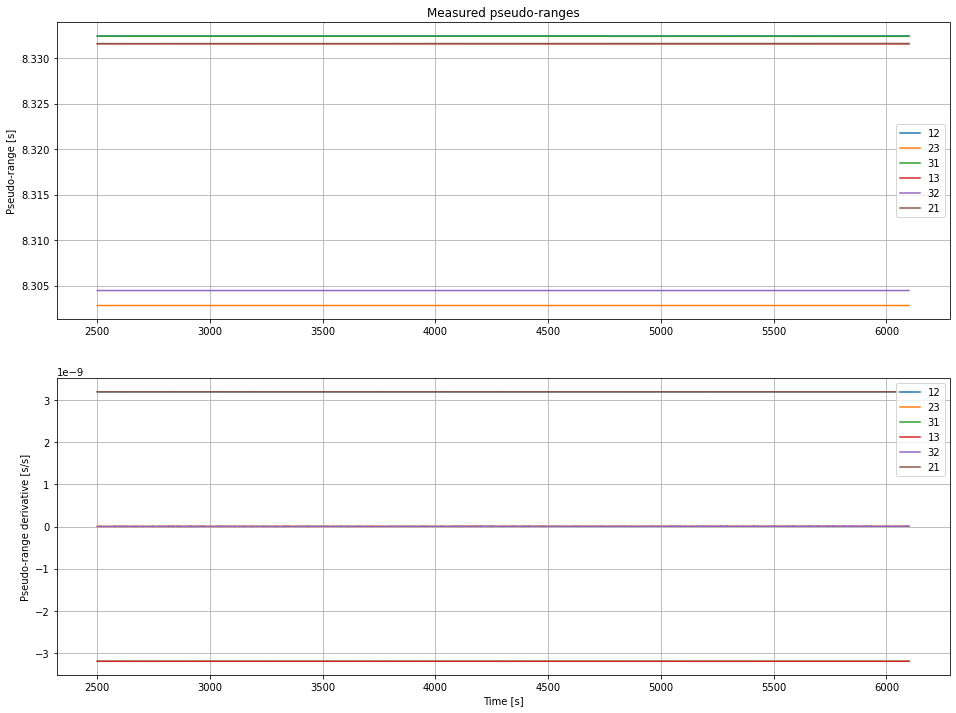

mosas order
['12', '23', '31', '13', '32', '21']


In [5]:
i.plot_mprs(output=None,skip=skipped)

mosas_order = i.MOSAS
print('mosas order')
print(mosas_order)


# Generate science, reference, and test-mass measuremenets

In [6]:

science_measurements = np.array([i.isi_carrier_fluctuations[mosa] for mosa in mosas_order])


TM_measurements = np.array([i.tmi_carrier_fluctuations[mosa] for mosa in mosas_order])


ref_measurements = np.array([i.rfi_carrier_fluctuations[mosa] for mosa in mosas_order])




# Get $\dot{L}_{ij}$, $L_{ij}$.

In [7]:
d_pprs = np.array([i.d_pprs[mosa] for mosa in mosas_order]) #pprs derivatives

mprs=np.array([i.mprs[mosa] for mosa in mosas_order])

# and $t_i$ for S/C for i$\in \{1,2,3\}$ in tcb frame. This may need to be modified depending on which version of LISA Orbits you're using. 

In [8]:


filename=orbit_filename


f = h5py.File(filename, 'r')
s_c_times = np.array([my_orbit.spacecraft_tcb[1],my_orbit.spacecraft_tcb[2],my_orbit.spacecraft_tcb[3]])

print(s_c_times)




[[0.00000000e+00 2.50000004e-01 5.00000007e-01 ... 6.09925009e+03
  6.09950009e+03 6.09975009e+03]
 [0.00000000e+00 2.50000004e-01 5.00000007e-01 ... 6.09925009e+03
  6.09950009e+03 6.09975009e+03]
 [0.00000000e+00 2.50000004e-01 5.00000007e-01 ... 6.09925009e+03
  6.09950009e+03 6.09975009e+03]]


# Concatenate all data for use in MCMC ($s_{ij}$,$\tau_{ij}$,$\varepsilon_{ij}$,$L_{ij}$, $\dot{L}_{ij}$ t (tcb time) and $\Delta t_i$ for S/C i in tcb) 

In [9]:
first_concat = np.concatenate((science_measurements,ref_measurements))
all_measurements = np.concatenate((first_concat,TM_measurements))
all_plus_mprs = np.concatenate((all_measurements,mprs))
all_plus_dpprs = np.concatenate((all_plus_mprs,d_pprs))
all_plus_time = np.concatenate((all_plus_dpprs,np.array([i.t])))
all_plus_times = np.concatenate((all_plus_time,s_c_times))
#all_plus_d_pprs = np.concatenate((all_measurements,d_pprs))
print('all_plus_times')
print(all_plus_times)
print(len(all_plus_times))


all_plus_times
[[ 2.17735706e+01 -3.95243345e+01  2.69921713e+01 ... -3.95023528e+02
  -4.00022352e+02 -3.53293439e+02]
 [-2.88524517e+01 -8.26794870e+01 -4.19312915e+01 ... -1.28034652e+01
  -1.67770612e+02 -9.42866055e+01]
 [-2.51469684e+01  4.79523716e+00 -3.88262093e+01 ...  3.36373416e+02
   2.69548025e+02  3.19388016e+02]
 ...
 [ 0.00000000e+00  2.50000004e-01  5.00000007e-01 ...  6.09925009e+03
   6.09950009e+03  6.09975009e+03]
 [ 0.00000000e+00  2.50000004e-01  5.00000007e-01 ...  6.09925009e+03
   6.09950009e+03  6.09975009e+03]
 [ 0.00000000e+00  2.50000004e-01  5.00000007e-01 ...  6.09925009e+03
   6.09950009e+03  6.09975009e+03]]
34


# Make .dat file for the above data sets separated by columns defined by header.

In [10]:
header = 's12 s23 s31 s13 s32 s21 tau12 tau23 tau31 tau13 tau32 tau21 eps12 eps23 eps31 eps13 eps32 eps21 mprs_12 mprs_23 mprs_31 mprs_13 mprs_32 mprs_21 d_pprs_12 d_pprs_23 d_pprs_31 d_pprs_13 d_pprs_32 d_pprs_21 time time_one time_two time_three'
np.savetxt(data_dir+'LISA_Instrument_Keplerian_orbits_{0}_orbits_{1}_Hz_{2}_sec.dat'.format(ref_frame_name,f_s,sec),all_plus_times.T,header = header)



In [11]:
print(i.t0)

0.0
